# PROCESS

0. **EXPLORATORY**
1. **READ EVERY IMAGE**
2. **FIND THE MOST DOMINANT COLOR PER IMAGE**
    * K-MEANS
        * [Benchmarking Performance and Scaling of Python Clustering Algorithms](https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html)
    * DOMINANT VS AVERAGE COLOR PROBLEM
        * [How to find the average colour of an image in Python with OpenCV?
]("https://stackoverflow.com/questions/43111029/how-to-find-the-average-colour-of-an-image-in-python-with-opencv")
    * store the results in a DF (image ID, dominant color's RGB code, percantage)
3. **FIND THE ID IN DF WHICH HAS THE HIGHEST PERCENTAGE OF THE GIVEN COLOR**
    * KDTREE
    * OUTPUT: PICTURE ID

# 0. EXPLORATORY

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree

### 0.1 IMAGE

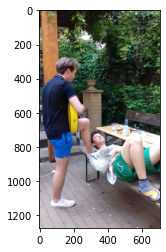

In [2]:
nemo = cv2.imread('images/IMAGE.jpg')
nemo = cv2.cvtColor(nemo, cv2.COLOR_BGR2RGB)

plt.imshow(nemo)
plt.show()

### 0.2 VISUALIZING IMAGE IN GRB COLOR SPACE

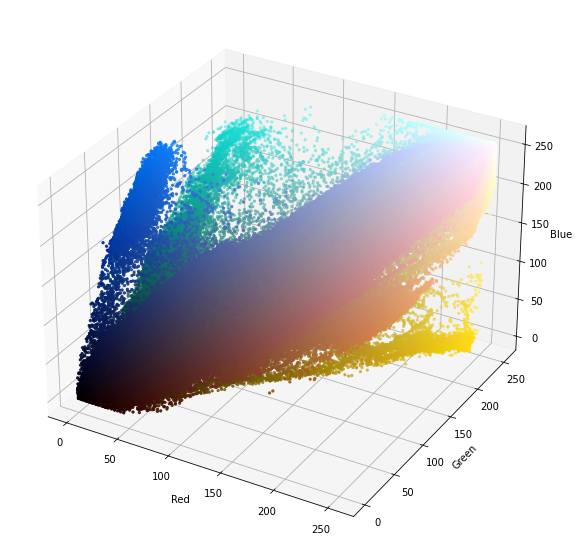

In [3]:
r, g, b = cv2.split(nemo)
fig = plt.figure(figsize=(10, 10))
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = nemo.reshape((np.shape(nemo)[0]*np.shape(nemo)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

### 0.3 VISUALIZING IMAGE IN HSV COLOR SPACE

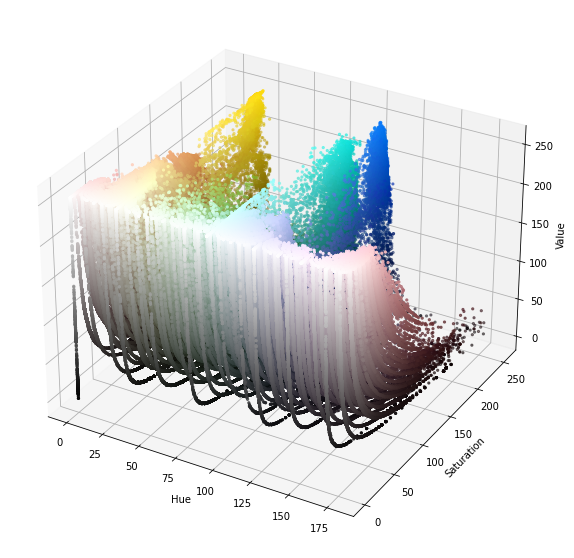

In [4]:
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)

h, s, v = cv2.split(hsv_nemo)
fig = plt.figure(figsize=(10, 10))
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

### 0.4 AVERAGE COLOR

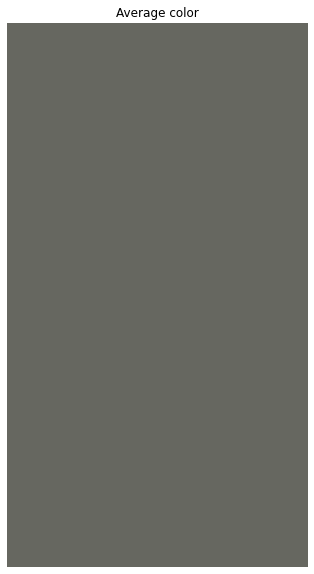

In [5]:
average = nemo.mean(axis=0).mean(axis=0)
avg_patch = np.ones(shape=nemo.shape, dtype=np.uint8)*np.uint8(average)    
fig, ax0 = plt.subplots(1, 1, figsize=(10,10))
ax0.imshow(avg_patch)
ax0.set_title('Average color')
ax0.axis('off')
plt.show(fig)

In [6]:
#from pyinstrument import Profiler
#
#"""
#mit mérsz
#"""
#
#profiler.stop()

In [7]:
#profiler.open_in_browser()

# 1. FIND DOMINANT COLOR

### 1.1 TAKE SAMPLE OF PIXELS, CLUSTER IN RGB COLOR SPACE, RETURN MOST DOMINANT COLOR CLUSTER AND ITS PERCENTAGE

In [8]:
def dominant_color(img, data):
    
    pixels = np.float32(img.reshape(-1, 3))
    pixels = pixels[np.random.choice(pixels.shape[0], 100_000), :]
    
    n_colors = 5
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    
    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 5, flags)
    _, counts = np.unique(labels, return_counts=True)
    
    dominant = palette[np.argmax(counts)]
    
    data = data.append(
        pd.DataFrame(
            np.append(dominant.tolist(), np.max(counts) / sum(counts)).reshape(1, -1),
            index=[str(str(image).split("/")[1])],
            columns=data.columns,
        )
    )
    return data

### 1.2 CREATE DATAFRAME TO STORE THE MOST DOMINANT COLOR OF UPLOADED PICTURES AND THEIR PERCENTAGE

In [9]:
df = pd.DataFrame(columns=["R", "G", "B", "pc"])

directory = "images"
image_names = []
file_exts = ["jpg", "jpeg", "JPG", "png"]

for filename in os.scandir(directory):
    if filename.is_file() and any(
        ext in str(str(filename).split(".")[-1]) for ext in file_exts
    ):
        image_names.append(filename.path)

In [10]:
%%time

np.random.seed(69)

for image in image_names:
    
    img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    df = dominant_color(img, df)

CPU times: user 5.79 s, sys: 76.5 ms, total: 5.86 s
Wall time: 2.18 s


In [97]:
df.to_dict(orient='records')[0]

{'R': 163.993896484375,
 'G': 168.21478271484375,
 'B': 173.35214233398438,
 'pc': 0.28006}

# 2. QUERY

### 2.1 TREE

In [17]:
p_multiplier = 100
q = np.array([[50, 110, 160, p_multiplier]])

In [18]:
def query(data, query):
    
    tree = KDTree((data.assign(pc=lambda data_: data_["pc"] * p_multiplier - p_multiplier)))
    dist, ind = tree.query(query, k=1)
    closest_file_name = data.iloc[ind[0][0], :].name
    return closest_file_name

In [20]:
%%time

closest_file_name = query(df, q)
closest_file_name

CPU times: user 2.58 ms, sys: 113 µs, total: 2.7 ms
Wall time: 2.63 ms


'4F9E9B17-C864-4CF4-8683-282BB926C8C4_1_105_c.jpeg'

### 2.2 SANITY CHECK

In [91]:
def plot(plot, color):
    
    color = np.array([[tuple(q[0][:3])]])
    
    closest = cv2.imread(f"images/{plot}")
    closest = cv2.cvtColor(closest, cv2.COLOR_BGR2RGB)
    
    fig, axs = plt.subplots(1,2,figsize=(16,9), gridspec_kw={'width_ratios': [1, 1]})
    axs[0].imshow(closest)
    axs[1].imshow(color)
    plt.tight_layout()

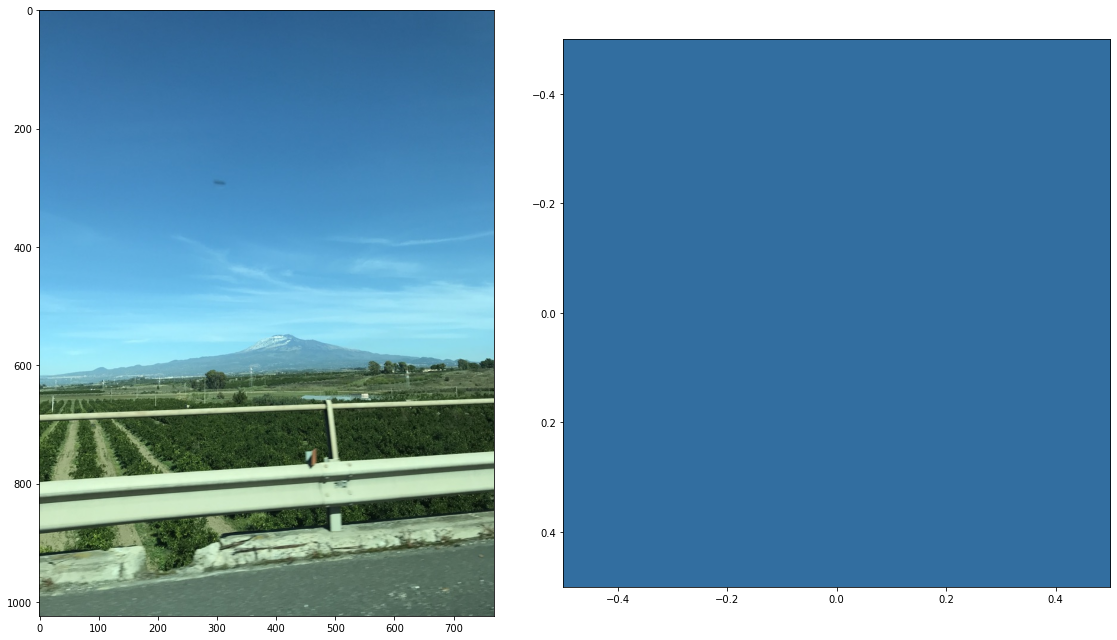

In [92]:
plot(closest_file_name, q)